In [1]:
from matplotlib import animation
import matplotlib.pyplot as plt

import numpy as np
import torch
from torch import nn
import torch.nn.functional as F

import random

from config import *
import objects
import pygame
from pygame.locals import *
import random
import time
import numpy as np
import torch

import pygame.surfarray as surfarray

pygame 2.4.0 (SDL 2.26.4, Python 3.11.4)
Hello from the pygame community. https://www.pygame.org/contribute.html


## Sources:

https://github.com/Dschobby/flappy_bird_reinforcement_learning

https://github.com/fschur/DDQN-with-PyTorch-for-OpenAI-Gym/blob/master/DDQN_discrete.py

https://gist.github.com/botforge/64cbb71780e6208172bbf03cd9293553

https://www.pygame.org/docs/ref/surfarray.html

## Helper function

In [2]:
# This function is for converting frames as a output of the pygame.display to a gif and store them in the gifs-folder
# Source https://gist.github.com/botforge/64cbb71780e6208172bbf03cd9293553
def save_frames_as_gif(frames, episode, path='./gifs/', filename='flappybird_animation'):
    plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi=72)

    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    anim.save(path + filename + 'eps' + str(episode) + '.gif', writer='imagemagick', fps=100)

## Creating the class for the Neural Network

In [3]:
# Source: https://github.com/Dschobby/flappy_bird_reinforcement_learning/blob/main/agents/dqn_agent.py
# Creating the class for the NN for both the Online and the target Network
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        # Input is 3, because the observation space is 3
        self.linear1 = nn.Linear(3, 128)
        # Output is 2, because action space is 2
        self.linear2 = nn.Linear(128, 2)

    def forward(self, x):
        # Relu as a activation function
        y = self.linear2(F.relu(self.linear1(x)))
        return y

## Update parameter function

In [4]:
# Source: https://github.com/fschur/DDQN-with-PyTorch-for-OpenAI-Gym/blob/master/DDQN_discrete.py
# To update the target model based on the parameters of the online model
def update_parameters(current_model, target_model):
    target_model.load_state_dict(current_model.state_dict())

## Creating the agent class

In [5]:
# Source: https://github.com/Dschobby/flappy_bird_reinforcement_learning/blob/main/agents/dqn_agent.py
class DdqnAgent:
    def __init__(self, device):
        self.device = device
        # Set up the models
        # Q_1: Online network
        self.Q_1 = NeuralNetwork().to(device)
        # Q_2 Target network
        self.Q_2 = NeuralNetwork().to(device)

        #Set up experience buffer
        self.buffer = [[],[],[],[]]
        self.buffer_size = 10000

        #Training hyperparameters
        self.lr = 0.001
        self.batch_size = 64
        self.gamma = 0.2
        self.epsilon = 0.0

        # we only train Q_1
        for param in self.Q_2.parameters():
            param.requires_grad = False

        self.loss_fn = nn.SmoothL1Loss()
        self.optimizer = torch.optim.Adam(self.Q_1.parameters(), lr=self.lr)

    # Set the function for updating the target models parameters
    def update(self):
        update_parameters(self.Q_1, self.Q_2)

    # Select action function
    def choose_action(self, state, train):
        state = torch.Tensor(state).to(self.device)
        # Choose action according to epsilon greedy policy
        if np.random.rand() > self.epsilon or not train:
            with torch.no_grad():
                # Online model selects actions in the environment based on the state
                return self.Q_1(state).data.max(0)[1].detach().cpu()
        else:
            return torch.randint(2,(1,))[0]

    def train(self):
        #Check buffer size
        if len(self.buffer[0]) < self.batch_size:
            return 0
        #Delete old data from buffer if buffer size is surpassed
        if len(self.buffer[0]) > self.buffer_size:
            del self.buffer[0][0:len(self.buffer[0])-self.buffer_size]
            del self.buffer[1][0:len(self.buffer[1])-self.buffer_size]
            del self.buffer[2][0:len(self.buffer[2])-self.buffer_size]
            del self.buffer[3][0:len(self.buffer[3])-self.buffer_size]
        
        #Create data batch
        batch_ind = torch.randperm(len(self.buffer[0]))[0:self.batch_size]
        batch_state = torch.Tensor(self.buffer[0])[batch_ind].to(self.device)
        batch_next_state = torch.Tensor(self.buffer[1])[batch_ind].to(self.device)
        batch_action = torch.Tensor([self.buffer[3]]).long().reshape(len(self.buffer[3]),-1)[batch_ind].to(self.device)
        batch_reward = torch.Tensor(self.buffer[2])[batch_ind].to(self.device)

        # Source: https://github.com/fschur/DDQN-with-PyTorch-for-OpenAI-Gym/blob/master/DDQN_discrete.py
        # Online network for calculating the current q_values
        current_q_values = self.Q_1(batch_state).gather(1,batch_action)
        # Online network for calculating the next q_values
        next_q_values = self.Q_1(batch_next_state)
        # Validating with target network
        next_q_state_values = self.Q_2(batch_next_state)
        with torch.no_grad():
            max_next_q_values = next_q_state_values.gather(1, torch.max(next_q_values, 1)[1].unsqueeze(1)).squeeze(1)
        # Calculating expected q_values based on the max_next_q_values
        expected_q_values = batch_reward + (self.gamma * max_next_q_values)

        # Calculate the loss (nn.SmoothL1Loss())
        loss = self.loss_fn(current_q_values, expected_q_values.unsqueeze(1))

        # Backpropagation of the loss
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_value_(self.Q_1.parameters(), 100) # gradient clipping for preventing exploding gradients for the online network
        self.optimizer.step()
        
        # Return the loss
        return loss.item()


In [6]:
# Source: https://github.com/Dschobby/flappy_bird_reinforcement_learning/blob/main/game.py
#Pygame image loading
bird_image = pygame.image.load('assets/bluebird-upflap.png')
bird_image = pygame.transform.scale(bird_image, (BIRD_WIDTH, BIRD_HEIGHT))
pipe_image = pygame.image.load('assets/pipe-green.png')
pipe_image = pygame.transform.scale(pipe_image, (PIPE_WIDHT, PIPE_HEIGHT))
ground_image = pygame.image.load('assets/base.png')
ground_image = pygame.transform.scale(ground_image, (GROUND_WIDHT, GROUND_HEIGHT))
BACKGROUND = pygame.image.load('assets/background-day.png')
BACKGROUND = pygame.transform.scale(BACKGROUND, (SCREEN_WIDHT, SCREEN_HEIGHT))

# The main class for controling the game
class Game:
    def __init__(self, device):
        # Get the agent
        self.agent = DdqnAgent(device)
        print("Initialize game with: DdqnAgent")
        self.device = device

        #Game objects (Get initialized new every game played)
        self.bird = None
        self.ground = None
        self.pipes = None
        self.score = None
        self.turn = None

        #Training mode for agent
        self.train = False

    # Setting up the environment
    def init_game(self):
        #Initialize game objects
        self.bird = objects.Bird(bird_image)
        self.ground = objects.Ground(ground_image, 0)
        self.pipes = []
        self.score = 0
        self.turn = 0

        #Initialize pipes
        for i in range(3):
            #Pipe initial positions
            xpos = PIPE_DISTANCE * i + PIPE_DISTANCE
            ysize = random.randint(200, 300)

            #Append pipes to list
            self.pipes.append(objects.Pipe(pipe_image, False, xpos, ysize))
            self.pipes.append(objects.Pipe(pipe_image, True, xpos, SCREEN_HEIGHT - ysize - PIPE_GAP))

    def pipe_handling(self):
        #if pipes out of screen add new ones and remove old
        if vars(self.pipes[0])["pos"][0] <= -100:
            #Remove old pipes
            del self.pipes[0]
            del self.pipes[0]

            #New pipe initial positions
            xpos = PIPE_DISTANCE * 3 - 100
            ysize = random.randint(150, 350)

            #Append new pipes
            self.pipes.append(objects.Pipe(pipe_image, False, xpos, ysize))
            self.pipes.append(objects.Pipe(pipe_image, True, xpos, SCREEN_HEIGHT - ysize - PIPE_GAP))
                
    def collision(self):
        #Check ground and roof collision
        if vars(self.bird)["pos"][1] < 0 or vars(self.bird)["pos"][1] > SCREEN_HEIGHT - GROUND_HEIGHT - BIRD_HEIGHT:
            return True

        #Check for pipe collision
        if vars(self.pipes[0])["pos"][0] - vars(self.bird)["pos"][2] < vars(self.bird)["pos"][0] and vars(self.bird)["pos"][0] < vars(self.pipes[0])["pos"][0] +vars(self.pipes[0])["pos"][2]:
            if vars(self.pipes[0])["pos"][1] < vars(self.bird)["pos"][1] + vars(self.bird)["pos"][3] or vars(self.pipes[0])["pos"][1] - PIPE_GAP > vars(self.bird)["pos"][1]:
                return True

        return False

    # Function for updating the score (Number of pipes the bird passes)
    def score_update(self):
        if vars(self.bird)["pos"][0] == vars(self.pipes[0])["pos"][0]:
            self.score += 1
    
    # Get the current game state
    def game_state(self):
        state = []

        #Gamestate passing to the agent: 1-horizontal distance to next pipe, 2-vertical distance to lower next pipe, 3-bird speed
        for pipe in self.pipes:
            if vars(self.bird)["pos"][0] < vars(pipe)["pos"][0] + vars(pipe)["pos"][2]: #Check which pipe is the next one
                state.append((- vars(self.bird)["pos"][0] + vars(pipe)["pos"][2] + vars(pipe)["pos"][0]) / PIPE_DISTANCE)
                state.append((vars(pipe)["pos"][1] - PIPE_GAP/2 - vars(self.bird)["pos"][1] - vars(self.bird)["pos"][3] / 2) / SCREEN_HEIGHT * 2)
                break
        state.append(vars(self.bird)["speed"] / SPEED)

        return state
    
    # Set the rewards for the environment
    def reward(self):
        reward = 0.1 #reward of 0.1 for surviving
        if self.collision():
            reward = -10 #reward -10 for colliding

        return round(reward,4)

    # Run a game
    def main(self, draw, episode=0): 
        #Initialize pygame screen if wanted (if draw = True)
        if draw:
            pygame.init()
            screen = pygame.display.set_mode((SCREEN_WIDHT, SCREEN_HEIGHT))
            pygame.display.set_icon(bird_image)
            pygame.display.set_caption('Flappy Bird')
            clock = pygame.time.Clock()

            # Initialising frames for creating the gifs afterwards
            frames = []

        #Initialize game
        active_episode = True
        self.init_game()

        #Game loop
        while active_episode:
            if draw:
                clock.tick(30)
                screen.blit(BACKGROUND, (0, 0))

                for event in pygame.event.get():
                    if event.type == QUIT:
                        active_episode = False

            #Get and execute agent action
            state = self.game_state()
            action = self.agent.choose_action(state, self.train)
            if action == 1: self.bird.bump()
            if action == -1: active_episode = False

            #Updating environment
            self.bird.update()
            for pipe in self.pipes: pipe.update()
            self.score_update()
            
            #Remove pipes if out of screen and instantiate new ones
            self.pipe_handling()
            
            #Check for collisions
            if self.collision(): active_episode = False

            #Give state to experience buffer if in training mode of agent
            if self.train:
                vars(self.agent)["buffer"][0].append(state)
                vars(self.agent)["buffer"][1].append(self.game_state())
                vars(self.agent)["buffer"][2].append(self.reward())
                if action == 0: vars(self.agent)["buffer"][3].append(torch.Tensor([0]))
                if action == 1: vars(self.agent)["buffer"][3].append(torch.Tensor([1]))
            self.turn += 1
                
            #Update screen
            if draw:
                self.bird.draw(screen)
                self.ground.draw(screen)
                for pipe in self.pipes: pipe.draw(screen)

                # Get the data for every frame in the game
                frame_data = surfarray.array3d(screen) # https://www.pygame.org/docs/ref/surfarray.html
                # Rotate the frame data because it was rotated by 90 degree
                frame_data = np.transpose(frame_data, (1, 0, 2))
                # Appending those frames to the array
                frames.append(frame_data)
                pygame.display.update()

            #Terminate episode after reaching score of 100
            if self.score >= 100:
                active_episode = False

        #Quit pygame window
        if draw:
            # Running the function for creating the gif in the gif-folder
            save_frames_as_gif(frames, episode)
            pygame.display.quit()
            pygame.quit()

        return self.score

        
    def train_agent(self, draw, episodes, batches, hyperparameter):
        #Training control parameters
        convergence = 0 #parameter controlling if convergence happened
        loss = 0
        mean_score = []
        performance = []
        loss_history = []
        time_start = time.time()

        #Print training initials
        print("Start training process of agent")
        if self.device == "cuda": print("Using {} device".format(self.device), ": ", torch.cuda.get_device_name(0))
        else: print("Using {} device".format(self.device))
        print("Used training hyperparameters: ",hyperparameter)

        # Transfer the parameters from the online to the target network
        self.agent.update()

        self.train = True

        for episode in range(1, episodes + 1):

            #Specify episode lr and epsilon
            eps = hyperparameter["eps_end"] + (hyperparameter["eps_start"] - hyperparameter["eps_end"]) * np.exp(-1. * episode /episodes * 10)
            lr = hyperparameter["lr_end"] + (hyperparameter["lr_start"] - hyperparameter["lr_end"]) * np.exp(-1. * episode /episodes * 10)
            vars(self.agent)["lr"] = lr
            vars(self.agent)["batch_size"] = hyperparameter["batch_size"]
            vars(self.agent)["gamma"] = hyperparameter["gamma"]
            vars(self.agent)["epsilon"] = eps

            #Run an episode
            if episode % 100 == 0:
                # Save gifs every 100 episodes
                _ = self.main(True, episode)
            else:
                _ = self.main(draw, episode)
            
            #Train agent
            for i in range(batches):
                loss += self.agent.train()

            # Append mean loss for batches to loss_history for later visualization
            loss_history.append(round(loss/batches,2))

            #Test agent
            self.train = False
            test_score = self.main(False, episode)
            mean_score.append(test_score)
            performance.append(test_score)
            if test_score == 100: convergence += 1 #look if agent has perfectly performed the game
            else: convergence = 0
            
            #Print training perfomance log
            time_step = time.time()
            if episode % 10 == 0 or convergence == 2: 
                print("Episode: [{}/{}]".format(episode, episodes) + 
                    "    -Time: [{}<{}]".format(time.strftime("%M:%S", time.gmtime(time_step-time_start)), time.strftime("%M:%S", time.gmtime((time_step-time_start) * episodes/episode))) +
                    " {}s/it".format(round((time_step-time_start)/episode,1)) +
                    "    -Loss: {}".format(round(loss/batches,6)) + 
                    "    -MeanTestScore: {}".format(round(np.mean(mean_score[-2:]))))
                mean_score = []
            loss = 0

            #Terminate training if agent never collides after two training procedures in a row
            if convergence == 2: 
                print("Agent performed faultless")
                break
            self.train = True

            if episode % 10 == 0:
                # Every 10 episodes the paramters of the online network should be transferred to the target network
                self.agent.update()


        self.train = False
        
        print("Training finished after {} episodes".format(episode))
    
        return performance, loss_history

## Initialising and training of the agent

Initialize game with: DdqnAgent
Start training process of agent
Using cpu device
Used training hyperparameters:  {'lr_start': 0.0001, 'lr_end': 0.0001, 'batch_size': 128, 'gamma': 0.8, 'eps_start': 0.9, 'eps_end': 0.01}
Episode: [10/1000]    -Time: [00:00<00:24] 0.0s/it    -Loss: 0.496929    -MeanTestScore: 0
Episode: [20/1000]    -Time: [00:00<00:40] 0.0s/it    -Loss: 0.499718    -MeanTestScore: 0
Episode: [30/1000]    -Time: [00:01<00:49] 0.0s/it    -Loss: 0.449611    -MeanTestScore: 0
Episode: [40/1000]    -Time: [00:02<00:56] 0.1s/it    -Loss: 0.456262    -MeanTestScore: 0
Episode: [50/1000]    -Time: [00:03<01:03] 0.1s/it    -Loss: 0.483592    -MeanTestScore: 0
Episode: [60/1000]    -Time: [00:04<01:09] 0.1s/it    -Loss: 0.453956    -MeanTestScore: 0
Episode: [70/1000]    -Time: [00:05<01:16] 0.1s/it    -Loss: 0.431139    -MeanTestScore: 0
Episode: [80/1000]    -Time: [00:06<01:23] 0.1s/it    -Loss: 0.488308    -MeanTestScore: 0
Episode: [90/1000]    -Time: [00:08<01:30] 0.1s/it  

MovieWriter imagemagick unavailable; using Pillow instead.


Episode: [100/1000]    -Time: [00:11<01:55] 0.1s/it    -Loss: 0.489265    -MeanTestScore: 1
Episode: [110/1000]    -Time: [00:13<02:01] 0.1s/it    -Loss: 0.509467    -MeanTestScore: 2
Episode: [120/1000]    -Time: [00:15<02:06] 0.1s/it    -Loss: 0.476283    -MeanTestScore: 0
Episode: [130/1000]    -Time: [00:17<02:13] 0.1s/it    -Loss: 0.448907    -MeanTestScore: 0
Episode: [140/1000]    -Time: [00:19<02:20] 0.1s/it    -Loss: 0.447668    -MeanTestScore: 0
Episode: [150/1000]    -Time: [00:22<02:27] 0.1s/it    -Loss: 0.443533    -MeanTestScore: 4
Episode: [160/1000]    -Time: [00:24<02:34] 0.2s/it    -Loss: 0.4453    -MeanTestScore: 2
Episode: [170/1000]    -Time: [00:27<02:41] 0.2s/it    -Loss: 0.424858    -MeanTestScore: 2
Episode: [180/1000]    -Time: [00:30<02:49] 0.2s/it    -Loss: 0.363539    -MeanTestScore: 2
Episode: [190/1000]    -Time: [00:33<02:57] 0.2s/it    -Loss: 0.35828    -MeanTestScore: 2


MovieWriter imagemagick unavailable; using Pillow instead.


Episode: [200/1000]    -Time: [00:41<03:26] 0.2s/it    -Loss: 0.349537    -MeanTestScore: 7
Episode: [210/1000]    -Time: [00:45<03:34] 0.2s/it    -Loss: 0.347684    -MeanTestScore: 8
Episode: [220/1000]    -Time: [00:49<03:44] 0.2s/it    -Loss: 0.288473    -MeanTestScore: 30
Episode: [230/1000]    -Time: [00:54<03:56] 0.2s/it    -Loss: 0.277374    -MeanTestScore: 8
Episode: [240/1000]    -Time: [00:59<04:09] 0.2s/it    -Loss: 0.262503    -MeanTestScore: 46
Episode: [250/1000]    -Time: [01:06<04:25] 0.3s/it    -Loss: 0.235772    -MeanTestScore: 12
Episode: [260/1000]    -Time: [01:13<04:41] 0.3s/it    -Loss: 0.177523    -MeanTestScore: 26
Episode: [270/1000]    -Time: [01:20<04:56] 0.3s/it    -Loss: 0.161842    -MeanTestScore: 38
Episode: [280/1000]    -Time: [01:26<05:10] 0.3s/it    -Loss: 0.148332    -MeanTestScore: 1
Episode: [290/1000]    -Time: [01:33<05:22] 0.3s/it    -Loss: 0.143245    -MeanTestScore: 19


MovieWriter imagemagick unavailable; using Pillow instead.


Episode: [300/1000]    -Time: [01:44<05:49] 0.3s/it    -Loss: 0.122376    -MeanTestScore: 11
Episode: [310/1000]    -Time: [01:51<05:59] 0.4s/it    -Loss: 0.09785    -MeanTestScore: 2
Episode: [320/1000]    -Time: [01:58<06:09] 0.4s/it    -Loss: 0.106135    -MeanTestScore: 2
Episode: [330/1000]    -Time: [02:05<06:19] 0.4s/it    -Loss: 0.104387    -MeanTestScore: 4
Episode: [340/1000]    -Time: [02:11<06:27] 0.4s/it    -Loss: 0.101674    -MeanTestScore: 4
Episode: [350/1000]    -Time: [02:18<06:36] 0.4s/it    -Loss: 0.094909    -MeanTestScore: 4
Episode: [360/1000]    -Time: [02:25<06:44] 0.4s/it    -Loss: 0.096763    -MeanTestScore: 2
Episode: [370/1000]    -Time: [02:32<06:52] 0.4s/it    -Loss: 0.105202    -MeanTestScore: 6
Episode: [380/1000]    -Time: [02:39<06:59] 0.4s/it    -Loss: 0.116001    -MeanTestScore: 4
Episode: [390/1000]    -Time: [02:46<07:06] 0.4s/it    -Loss: 0.115453    -MeanTestScore: 4


MovieWriter imagemagick unavailable; using Pillow instead.


Episode: [400/1000]    -Time: [02:56<07:20] 0.4s/it    -Loss: 0.087986    -MeanTestScore: 4
Episode: [410/1000]    -Time: [03:03<07:27] 0.4s/it    -Loss: 0.078152    -MeanTestScore: 26
Episode: [420/1000]    -Time: [03:10<07:34] 0.5s/it    -Loss: 0.067716    -MeanTestScore: 8
Episode: [430/1000]    -Time: [03:18<07:41] 0.5s/it    -Loss: 0.055374    -MeanTestScore: 32
Episode: [440/1000]    -Time: [03:25<07:47] 0.5s/it    -Loss: 0.041182    -MeanTestScore: 16
Episode: [450/1000]    -Time: [03:33<07:53] 0.5s/it    -Loss: 0.038925    -MeanTestScore: 35
Episode: [460/1000]    -Time: [03:40<07:59] 0.5s/it    -Loss: 0.044451    -MeanTestScore: 12
Episode: [470/1000]    -Time: [03:47<08:04] 0.5s/it    -Loss: 0.04253    -MeanTestScore: 53
Episode: [479/1000]    -Time: [03:54<08:09] 0.5s/it    -Loss: 0.029284    -MeanTestScore: 100
Agent performed faultless
Training finished after 479 episodes


MovieWriter imagemagick unavailable; using Pillow instead.


Score:  36


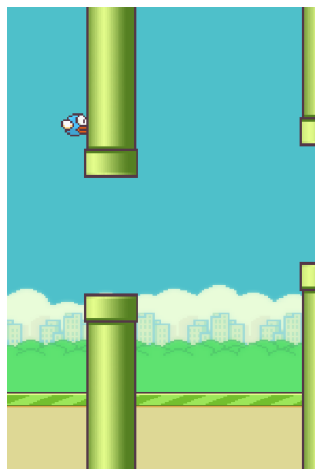

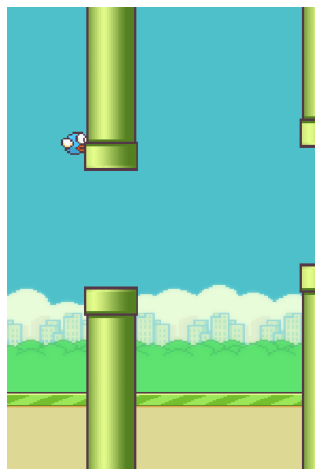

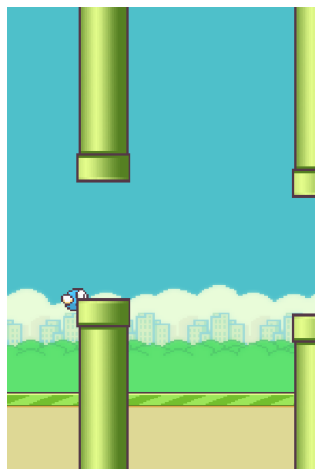

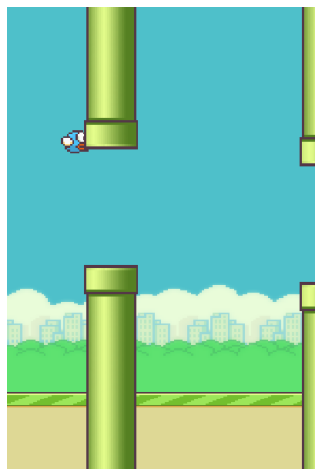

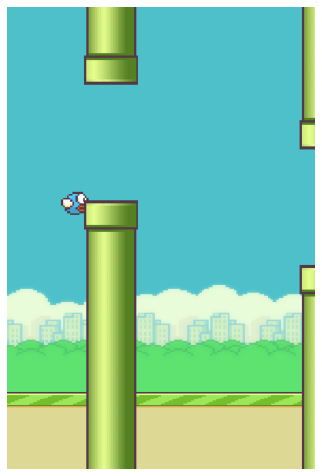

In [7]:
# Source: https://github.com/Dschobby/flappy_bird_reinforcement_learning/blob/main/main.py
# Initialize the game (type cuda if available)
game = Game("cpu")

# Setting the hyperparamater
hyperparameter = {
  "lr_start": 1e-4,
  "lr_end": 1e-4,
  "batch_size": 128,
  "gamma": 0.8,
  "eps_start": 0.9,
  "eps_end": 1e-2
}
    
# Get the performance and the loss of each episode
returned_performance, returned_loss = game.train_agent(False, 1000, 100, hyperparameter)  

# Get a testing score
score = game.main(True, 1000)
print("Score: ", score)

## Display the performance and the loss for the training

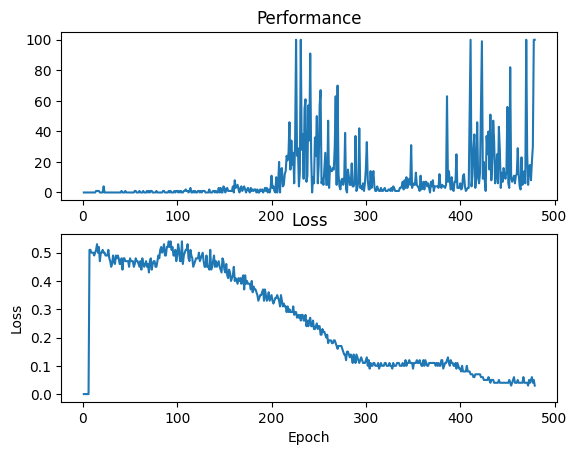

In [9]:
# Plot the performance and the loss of each episode
fig, axes = plt.subplots(nrows=2, ncols=1)

axes[0].plot(list(range(1, len(returned_performance)+1)), returned_performance)
axes[0].set_title('Performance')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Performance')

axes[1].plot([i for i in range(1, len(returned_loss)+1)], returned_loss)
axes[1].set_title('Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')

plt.show()